# Домашнее задание №2

Выполнили студентки группы БЭК182: Оганесян Мария и Бадаева Санчир.

## Импорт библиотек

In [131]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pandas import read_csv, DataFrame
import statsmodels.api as sm
from statsmodels.iolib.table import SimpleTable
from sklearn.metrics import r2_score
from matplotlib import pyplot

## 1. Взять языка

В №1-5 будудт использованы данные о скорости ветра в Нью-Дели за период с января 2013 года по апрель 2017 года (включительно). 

Единица измерения - км/ч.

Источник: https://www.kaggle.com/sumanthvrao/daily-climate-time-series-data

In [132]:
ws = pd.read_csv('wind_speed_final.csv')
ws.head()

,N,date,wind_speed
0,1,2013-01-01,3.000000
1,2,2013-02-01,2.220000
2,3,2013-03-01,24.066668
3,4,2013-04-01,4.400000
4,5,2013-05-01,12.685715


In [133]:
ws.index = pd.PeriodIndex(ws.date, freq = 'M')
ws.head()

,N,date,wind_speed
date,,,
2013-01,1,2013-01-01,3.000000
2013-02,2,2013-02-01,2.220000
2013-03,3,2013-03-01,24.066668
2013-04,4,2013-04-01,4.400000
2013-05,5,2013-05-01,12.685715


## 2. Намалевич

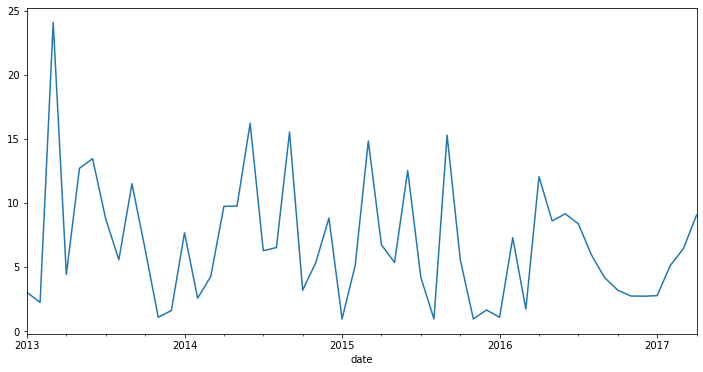

In [134]:
ws.wind_speed.plot(figsize=(12,6))
plt.show()

In [135]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

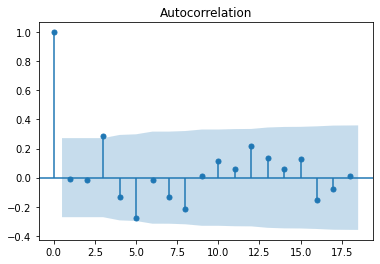

In [136]:
plot_acf(ws.wind_speed)
plt.show()

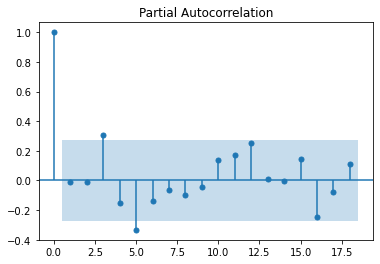

In [137]:
plot_pacf(ws.wind_speed)
plt.show()

Нарезка на годы. 

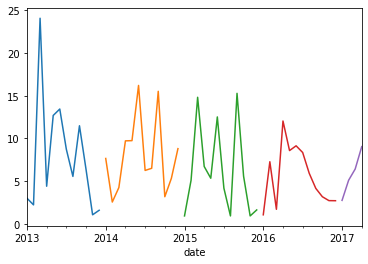

In [138]:
ws.wind_speed[0:12].plot()
ws.wind_speed[12:24].plot()
ws.wind_speed[24:36].plot()
ws.wind_speed[36:48].plot()
ws.wind_speed[48:].plot()
plt.show()

## 3. Твиттер

Сезонность: в целом, можно сказать, что ряд является сезонным. По графику с нарезкой по годам видно, что есть примерно три пика скорости ветра в Нью-Дели и три нижние точки. То есть приблизительно в одни и те же месяцы ежегодно скорость ветра достигает своих максимальных значений и примерно в одни и те же месяцы каждого года она достигает минимума. 
Явное исключение составляет только значения в начале 2013 года, когда скорость ветра достигла своего максимального значения за весь период в 52 месяца.

Тренд: как видно по первому графику, как такого конкретного тренда выделить нельзя. Скорость ветра постоянно колеблется, однако это происходит примерно в одном и том же диапазоне, и значения выборки таким образом не выходят за пределы определенного коридора. 

Стационарность: по графику видно, что ряд является стационарным.

Точки излома: да, они есть на протяжении всего временного ряда.

Амплитуда: как было указано выше, колебания происходят внутри определенного коридора на проятжении всего периода, а также точки излома находятся примерно на одном и том же уровне (верхние с верхними, нижние с нижними), что видно по графикам, соответственно, амплитуда почти всё время одинаковая.

In [139]:
from sktime.utils.plotting import plot_series
from sktime.forecasting.base import ForecastingHorizon
from sktime.performance_metrics.forecasting import (
    MeanAbsoluteError,
    mean_absolute_error)
from sktime.forecasting.model_evaluation import evaluate

In [140]:
ws_train = ws.wind_speed[0:40]
ws_test = ws.wind_speed[40:]

In [141]:
fh = ForecastingHorizon(ws_test.index,is_relative=False)
fh

ForecastingHorizon(['2016-05', '2016-06', '2016-07', '2016-08', '2016-09', '2016-10',
             '2016-11', '2016-12', '2017-01', '2017-02', '2017-03', '2017-04'],
            dtype='period[M]', name='date', freq='M', is_relative=False)

## 4. Двенадцать месяцев

### Наивная модель

In [142]:
from sktime.forecasting.naive import NaiveForecaster

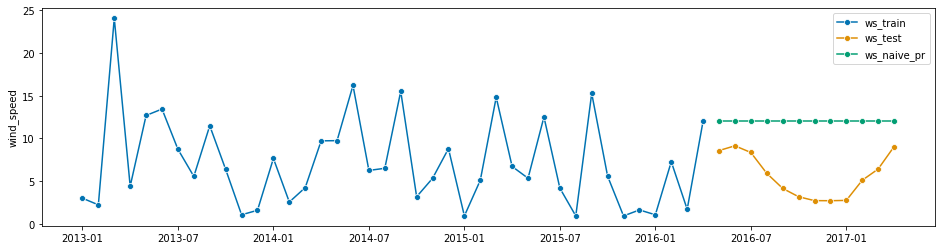

In [143]:
naive = NaiveForecaster(strategy="last")
naive.fit(ws_train)
ws_naive_pr = naive.predict(fh)
plot_series(ws_train, ws_test, ws_naive_pr, labels=['ws_train','ws_test', 'ws_naive_pr'])
plt.show()

Поиск MAE

In [144]:
mean_absolute_error(ws_naive_pr, ws_test)

6.36858238776525

### Сезонная наивная

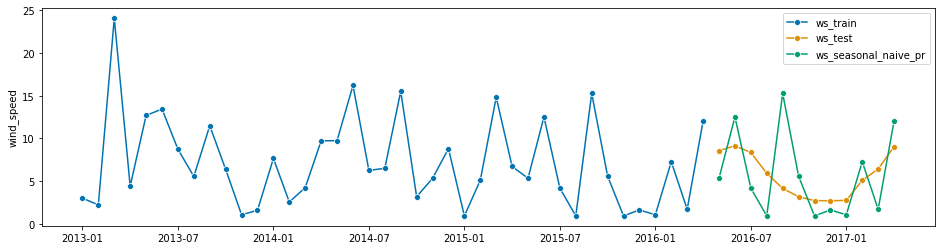

In [145]:
seasonal_naive = NaiveForecaster(strategy="last", sp=12)
seasonal_naive.fit(ws_train)
ws_seasonal_naive_pr = seasonal_naive.predict(fh)
plot_series(ws_train, ws_test, ws_seasonal_naive_pr, labels=['ws_train','ws_test', 'ws_seasonal_naive_pr'])
plt.show()

Поиск MAE

In [146]:
mean_absolute_error(ws_seasonal_naive_pr, ws_test)

3.645754079023997

### SARIMA (1, 1, 1) (1 0, 0) [12]

In [147]:
from sktime.forecasting.arima import AutoARIMA
from sktime.forecasting.arima import ARIMA

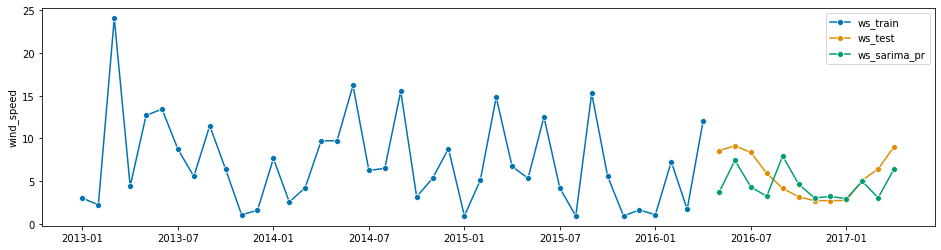

In [148]:
sarima = ARIMA(order = (1,1,1), seasonal_order = (1,0,0,12), suppress_warnings=True)
sarima.fit(ws_train)
ws_sarima_pr = sarima.predict(fh)
plot_series(ws_train, ws_test, ws_sarima_pr, labels=['ws_train','ws_test', 'ws_sarima_pr'])
plt.show()

Поиск MAE

In [149]:
mean_absolute_error(ws_sarima_pr, ws_test)

2.1438605249567373

### Алгоритм Хиндмана-Хандакара автоматического подбора SARIMA

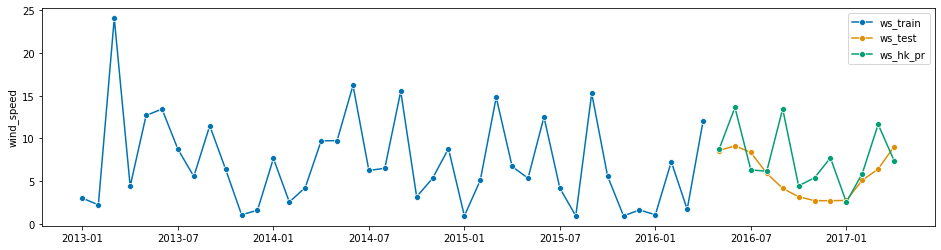

In [150]:
hk = AutoARIMA(sp = 12, suppress_warnings = True)
hk.fit(ws_train)
ws_hk_pr = hk.predict(fh)
plot_series(ws_train, ws_test, ws_hk_pr, labels=['ws_train','ws_test', 'ws_hk_pr'])
plt.show()

Поиск MAE

In [151]:
mean_absolute_error(ws_hk_pr, ws_test)

2.7527031449580037

### ETS(AAA)

In [152]:
from sktime.forecasting.exp_smoothing import ExponentialSmoothing
from statsmodels.tsa.exponential_smoothing.ets import ETSModel

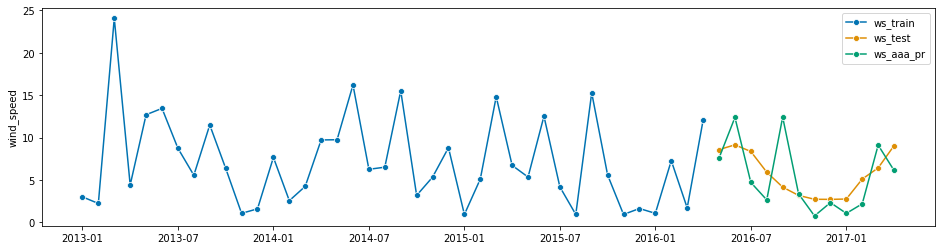

In [153]:
ets_aaa = ETSModel(ws_train, error = 'add', trend = 'add', seasonal = 'add')
ets_aaa_fit = ets_aaa.fit()
ws_aaa_pr = ets_aaa_fit.get_prediction(start='2016-05', end='2017-04')
ws_aaa_pr = ws_aaa_pr.summary_frame(alpha=0.05)
plot_series(ws_train, ws_test, ws_aaa_pr['mean'], labels=['ws_train','ws_test', 'ws_aaa_pr'])
plt.show()

Поиск MAE

In [154]:
mean_absolute_error(ws_aaa_pr['mean'], ws_test)

2.6805563207988334

### ETS с автоматическим выбором по AIC

In [155]:
from sktime.forecasting.ets import AutoETS

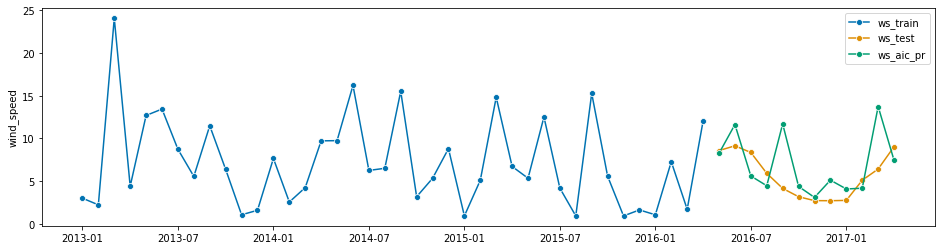

In [156]:
ets_aic = AutoETS(auto = True, sp = 12, information_criterion = 'aic', n_jobs = -1)
ets_aic.fit(ws_train)
ws_aic_pr = ets_aic.predict(fh)
plot_series(ws_train, ws_test, ws_aic_pr, labels=['ws_train','ws_test', 'ws_aic_pr'])
plt.show()

Поиск MAE

In [157]:
mean_absolute_error(ws_aic_pr, ws_test)

2.479567057484535

Итак, список прогнозов от наименее к наиболее качественному при оценке с помощью MAE:

Наивная модель

Сезонная наивная

Алгоритм Хиндмана-Хандакара автоматического подбора SARIMA

ETS(AAA)

ETS с автоматическим выбором по AIC

SARIMA(1, 1, 1)(1, 0, 0)[12]

## 5. Кто на свете всех милее?

Наилучшей моделью будет та, у которой наименьшее значение MAE. В данном случае это SARIMA(1, 1, 1)(1, 0, 0)[12].

Построим прогноз

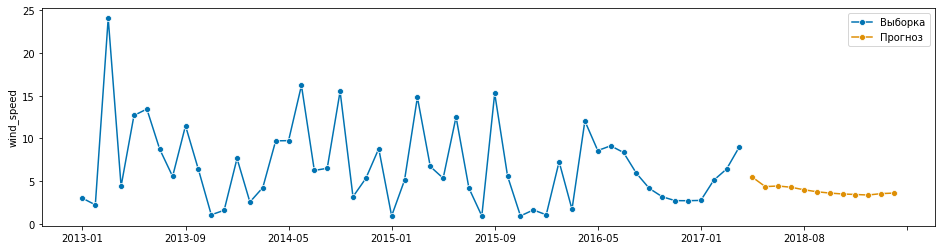

In [158]:
fh_new= np.arange(len(ws_test))+12
sarima_new = ARIMA(order = (1,1,1), seasonal_order = (1,0,0,12), suppress_warnings=True)
sarima_new.fit(ws.wind_speed)
ws_sarima_new_pr = sarima_new.predict(fh_new)
plot_series(ws.wind_speed,ws_sarima_new_pr, labels=['Выборка','Прогноз'])
plt.show()

## 6. Хождение в народ

Используется объединенная база данных RLMS за 1994-2019 годы по индивидам.

In [159]:
dataset = pd.read_csv('yekz.csv', usecols = ['year', 'id', 'j2051b', 'j2054b'],\
index_col = ['id', 'year'])
years = dataset.index.get_level_values('year').to_list()
dataset['year'] = pd.Categorical(years)
dataset

j2051b  j2054b  year
id    year                      
1     2006     360      90  2006
2     2006       0       0  2006
3     2008       0       0  2008
      2009     180       0  2009
5     2007     180      60  2007
...            ...     ...   ...
32287 2009     200      60  2009
35543 2006       0       0  2006
44509 2007      20      50  2007
      2008      40      40  2008
      2009      30      60  2009

[32323 rows x 3 columns]

In [160]:
fl = pd.read_csv('yekz.csv', usecols = ['year', 'id', 'j2051b', 'j2054b'],\
index_col = ['id', 'year'])
ids = fl.index.get_level_values('id').to_list()
fl['id'] = pd.Categorical(ids)
fl #для графика

j2051b  j2054b     id
id    year                       
1     2006     360      90      1
2     2006       0       0      2
3     2008       0       0      3
      2009     180       0      3
5     2007     180      60      5
...            ...     ...    ...
32287 2009     200      60  32287
35543 2006       0       0  35543
44509 2007      20      50  44509
      2008      40      40  44509
      2009      30      60  44509

[32323 rows x 3 columns]

Индексы: id (единый идентификационный номер индивида), year (год проведения волны).

## 7. Кому на Руси жить хорошо? 

### Вопрос:

Влияет ли количество затраченных на дорогу минут (J205.1B) на приготовление еды (J205.4B) в рабочий/учебный день?

**J205.1B Сколько всего минут в обычный (рабочий/учебный) день Вы ездили на работу, учебу и обратно?**
<br>
99999997 - Затрудняюсь ответить
<br>
99999998 - Отказ от ответа
<br>
99999999 - Нет ответа

**J205.4B Сколько всего минут в обычный (рабочий/учебный) день Вы готовили еду?**
<br>
99999997 - Затрудняюсь ответить
<br>
99999998 - Отказ от ответа
<br>
99999999 - Нет ответа

Всего 32323 наблюдений. 

In [161]:
dataset.shape

(32323, 3)

Временной период - 2006-2009 гг.

In [162]:
print(min(dataset['year']))
print(max(dataset['year']))

2006
2009


In [163]:
dataset = dataset.sort_index()
dataset

j2051b  j2054b  year
id    year                      
1     2006     360      90  2006
2     2006       0       0  2006
3     2008       0       0  2008
      2009     180       0  2009
5     2007     180      60  2007
...            ...     ...   ...
32287 2009     200      60  2009
35543 2006       0       0  2006
44509 2007      20      50  2007
      2008      40      40  2008
      2009      30      60  2009

[32323 rows x 3 columns]

## 8. Сделай красиво!

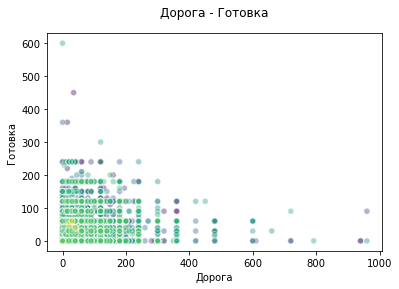

In [164]:
%matplotlib inline
import matplotlib as mpl

plt.scatter(fl['j2051b'], fl['j2054b'], c=fl['id'], alpha=0.4, edgecolors='w')

plt.xlabel('Дорога')
plt.ylabel('Готовка')
plt.title('Дорога - Готовка',y=1.05)
plt.show()

## 9. Три сестры

In [165]:
from linearmodels import PanelOLS
from linearmodels import RandomEffects
from linearmodels import PooledOLS
import statsmodels.api as sm

### Pooled OLS

In [166]:
exog = sm.tools.tools.add_constant(dataset['j2051b'])
endog = dataset['j2054b']
mod = PooledOLS(endog, exog)
pooledOLS_res = mod.fit(cov_type='clustered', cluster_entity=True)
print(pooledOLS_res)

                          PooledOLS Estimation Summary                          
Dep. Variable:                 j2054b   R-squared:                        0.0049
Estimator:                  PooledOLS   R-squared (Between):              0.0033
No. Observations:               32323   R-squared (Within):              4.5e-05
Date:                Tue, Jun 15 2021   R-squared (Overall):              0.0049
Time:                        20:45:46   Log-likelihood                -1.651e+05
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      158.63
Entities:                       13199   P-value                           0.0000
Avg Obs:                       2.4489   Distribution:                 F(1,32321)
Min Obs:                       1.0000                                           
Max Obs:                       4.0000   F-statistic (robust):             101.46
                            

Проверяем гомоскедастичность. 

In [167]:
fittedvals_pooled_OLS = pooledOLS_res.predict().fitted_values
residuals_pooled_OLS = pooledOLS_res.resids

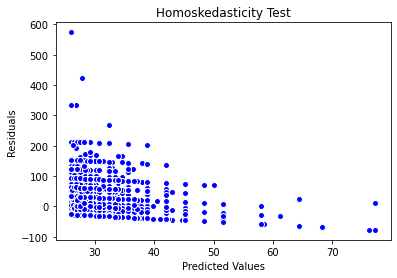

In [168]:
fig, ax = plt.subplots()
ax.scatter(fittedvals_pooled_OLS, residuals_pooled_OLS, color = 'blue', edgecolors='w')
ax.set_xlabel('Predicted Values')
ax.set_ylabel('Residuals')
ax.set_title('Homoskedasticity Test')
plt.show()

График говорит о присутствии гетероскедастичности. Проверим с помощью **теста Бройша - Пагана**. 

In [169]:
from statsmodels.stats.diagnostic import het_breuschpagan
pooled_OLS_dataset = pd.concat([dataset, residuals_pooled_OLS], axis=1)
pooled_OLS_dataset = pooled_OLS_dataset.drop(['year'], axis = 1).fillna(0)
exog = sm.tools.tools.add_constant(dataset['j2051b']).fillna(0)
breusch_pagan_test_results = het_breuschpagan(pooled_OLS_dataset['residual'], exog)
labels = ['LM-Stat', 'LM p-val', 'F-Stat', 'F p-val'] 
print(dict(zip(labels, breusch_pagan_test_results)))

{'LM-Stat': 8.035503713472345, 'LM p-val': 0.004586925281879644, 'F-Stat': 8.037004513899364, 'F p-val': 0.004585969677993278}


Также можно было бы провести **тест Уайта**. 

In [170]:
from statsmodels.stats.diagnostic import het_white
white_test_results = het_white(pooled_OLS_dataset['residual'], exog) 
print(dict(zip(labels, white_test_results)))

{'LM-Stat': 8.671097728933695, 'LM p-val': 0.013094684892987063, 'F-Stat': 4.336309744303993, 'F p-val': 0.013092338667668953}


P-value < 0.05, следовательно, мы наблюдаем гетероскедастичность. 

Проведем **тест Дарбина - Уотсона** на наличие автокорреляции. 

In [171]:
from statsmodels.stats.stattools import durbin_watson
durbin_watson_test_results = durbin_watson(pooled_OLS_dataset['residual']) 
print(durbin_watson_test_results)

1.354125538233904


Полученное значение говорит о наличии положительной автокорреляции. 

Таким образом, ввиду автокорреляции и гетероскедастичности, модели с фиксированными и случайными эффектами будут более предпочтительны. 

### Random Effects Model

In [172]:
exog = sm.tools.tools.add_constant(dataset['j2051b'])
endog = dataset['j2054b']
model_re = RandomEffects(endog, exog) 
re_res = model_re.fit() 
print(re_res)

                        RandomEffects Estimation Summary                        
Dep. Variable:                 j2054b   R-squared:                        0.0200
Estimator:              RandomEffects   R-squared (Between):              0.0040
No. Observations:               32323   R-squared (Within):               0.0014
Date:                Tue, Jun 15 2021   R-squared (Overall):              0.0038
Time:                        20:45:49   Log-likelihood                -1.496e+05
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      657.98
Entities:                       13199   P-value                           0.0000
Avg Obs:                       2.4489   Distribution:                 F(1,32321)
Min Obs:                       1.0000                                           
Max Obs:                       4.0000   F-statistic (robust):             84.359
                            

### Fixed Effects Model

In [173]:
model_fe = PanelOLS(endog, exog, entity_effects = True) 
fe_res = model_fe.fit() 
print(fe_res)

                          PanelOLS Estimation Summary                           
Dep. Variable:                 j2054b   R-squared:                        0.0016
Estimator:                   PanelOLS   R-squared (Between):              0.0022
No. Observations:               32323   R-squared (Within):               0.0016
Date:                Tue, Jun 15 2021   R-squared (Overall):              0.0037
Time:                        20:45:49   Log-likelihood                -1.412e+05
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      31.386
Entities:                       13199   P-value                           0.0000
Avg Obs:                       2.4489   Distribution:                 F(1,19123)
Min Obs:                       1.0000                                           
Max Obs:                       4.0000   F-statistic (robust):             31.386
                            

Снова убеждаемся в необходимости отказаться от сквозной регрессии, так как p-value = 0 и нулевая гипотеза F-теста отвергается. 

Для того, чтобы выбрать между FE и RE, проведем **тест Хаусмана**. 

In [174]:
import numpy.linalg as la
from scipy import stats

def hausman(fe, re):
    b = fe.params
    B = re.params
    v_b = fe.cov
    v_B = re.cov
    df = b[np.abs(b) < 1e8].size
    chi2 = np.dot((b-B).T, la.inv(v_b-v_B).dot(b-B)) 
    pval = stats.chi2.sf(chi2, df)
    return chi2, df, pval

hausman_results = hausman(fe_res, re_res) 
print('chi-Squared: ' + str(hausman_results[0]))
print('degrees of freedom: ' + str(hausman_results[1]))
print('p-Value: ' + str(hausman_results[2]))

chi-Squared: 0.6609428380251448
degrees of freedom: 2
p-Value: 0.7185848989881713


Так как p-value > 0.05, нулевая гипотеза не отвергается и **модель со случайными эффектами является наилучшим выбором**. 

## 10. Ответ на главный вопрос

Модель со случайными эффектами иллюстрирует положительную корреляцию между j2051b и j2054b. Увеличение j2051b на одну единицу приведет к увеличению j2054b на 0.0362 единицы. Таким образом, время, затраченное на дорогу на работу/учебу, положительно влияет на продолжительность приготовления еды в рабочий/учебный день. 

## Источники

1. https://towardsdatascience.com/a-guide-to-panel-data-regression-theoretics-and-implementation-with-python-4c84c5055cf8
2. https://www.kaggle.com/sumanthvrao/daily-climate-time-series-data
3. https://www.hse.ru/rlms/